### Time Evolution of Spinor Containing Spin-Orbit Term In Barrier Potential Using Split Operator Method
---

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

### Theory :
---

The Hamiltonian of the system containing spin orbit coupling is as follows

$$ \hat{H} = -\dfrac{\hbar^2}{2m}\dfrac{\hat{d}^2}{dz^2} + \hat{V}(z) + \dfrac{\hbar^2}{4m^2c^2}\dfrac{d\hat{V}(z)}{dz}\hat{\vec{s}}\times\hat{\vec{p}}\cdot\nabla V $$

If we expand spin using Pauli Matrices $s=\hbar\mathbf{\sigma}$

$$ \hat{H} = -\dfrac{\hbar^2}{2m}\dfrac{\hat{d}^2}{dz^2} + \hat{V}(z) + \dfrac{\hbar^2}{4m^2c^2}\dfrac{d\hat{V}(z)}{dz}\hat{K} $$

The $\hat{K}$ matrix defined has the following form :

$$ \hat{K} = \begin{pmatrix} 0 & k^+ \\ k^- & 0 \end{pmatrix} $$

Here $k^+=k_x+ik_y$ and $k^-=k_x-ik_y$. Then they move to define the spinor wavefunction as, 

$$ \psi(z, t) = \begin{pmatrix} \phi_{\uparrow}(z,t) \\ \phi_{\downarrow}(z,t) \end{pmatrix} $$

In [16]:
class SplitOperatorEvolution:
    def __init__(self, m, a, V, dVdz, Lzi, Lzf):
        self.m = m
        self.a = a
        self.V = V
        self.dVdz = dVdz
        self.Lzi = Lzi
        self.Lzf = Lzf
 
    # Generates paramters necessary for time evolution, involves large matrix inversions and multiplications 
    def gen_calc_params(self, k_plus, k_minus, del_z, del_t):
        gamma, rho, lamda = 2*self.m*(del_z**2), (del_z**2)/(2*self.m*(c**2)),  4*self.m*(del_z**2)/del_t 
        
        z = np.arange(self.Lzi, self.Lzf, del_z) 
        Nz = len(z)
        V, dVdz = self.V(z), self.dVdz(z)  

        ca = lambda cj : (gamma*V[cj] - 2 + complex(0, lamda)) 
        cb = lambda cj : (-gamma*V[cj] + 2 + complex(0, lamda)) 

        a = np.zeros(Nz, dtype=complex) # main diagonal
        b = np.zeros(Nz, dtype=complex) # main diagonal
        for j in range(Nz):
            a[j] = ca(j)
            b[j] = cb(j)

        # create the tridiagonal matrix as a 2D numpy array
        B = np.diag(b) + np.diag(-np.ones(Nz-1), k=1) + np.diag(-np.ones(Nz-1), k=-1)
        A = np.diag(a) + np.diag(np.ones(Nz-1), k=1) + np.diag(np.ones(Nz-1), k=-1)

        # Diagonal Matrix of Potential and its Derivative 
        eta = np.diag(dVdz)
        Vmat = np.diag(V)
        # Intermediate Parameters
        BB = rho*eta*k_plus 
        A_inv = np.linalg.inv(A)
        AiB = np.matmul(A_inv, BB)
        Y0 = np.linalg.inv(np.identity(Nz) - np.matmul(AiB, AiB))
        Y1 = np.matmul(np.matmul(Y0, A_inv), BB)
        Y2 = np.matmul(Y1, A_inv)
        # Returning some importnt parameters
        return z, rho, A_inv, B, AiB, eta, Y1, Y2

    def prepare_psi0(self, z, k, z0, sig0):
        cols = len(z)
        psi = np.empty((2, cols), dtype=complex) # Defining the complex spinor wave function
        
        for i in range(cols):
            term1 = complex(0, k*z[i])
            term2 = (-(z[i] - z0)**2)/(2*sig_0**2)
            term3 = np.sqrt(sig_0 * np.sqrt(np.pi))
            
            const = np.exp(term1) * np.exp(term2) / term3 
            spinor = np.array([1, 0])
            psi[:, i] = spinor*const
        return psi # Returns spinor wave function along with the norm of the spinor wavefunction

    def propagate(self, kx, ky, z0, sig0, del_z, del_t, steps):
        # Some important parameters
        k_plus = complex(kx, ky)
        k_minus = complex(kx, -ky)
        z, rho, A_inv, B, AiB, eta, Y1, Y2 = self.gen_calc_params(k_plus, k_minus, del_z, del_t)
        Nz = len(z)

        psi0 = self.prepare_psi0(z, k, z0, sig0) # Initializing psi0 of Gaussian form
        psi = np.empty((2, Nz, steps), dtype=complex)
        psi[:, :, 0] = psi0.copy() # Assigning the first entry of the complex psi array

        for i in range(steps - 1):
            c1 = np.matmul(B, psi[0, :, i]) + rho*k_plus*np.matmul(eta, psi[1, :, i])
            c2 = np.matmul(B, psi[1, :, i]) + rho*k_minus*np.matmul(eta, psi[0, :, i])

            psi[1, :, i+1] = np.matmul(Y1, c2) + np.matmul(Y2, c1)
            psi[0, :, i+1] = np.matmul(AiB, psi[1, :, i]) + np.matmul(A_inv, c1)
            psi[:, 0, i+1], psi[:, -1, i+1] = 0., 0.
       
        return z, psi
    
    def time_step_plot(self, step, z, psi):
        ymax = max(np.abs(psi[0, :, 0])) + 0.2
        ymin = min(self.V(z)) - 0.2

        # Setting up figure
        fig, ax = plt.subplots(figsize=(10, 6))
        ax = plt.axes(xlim=(-Lz, Lz), ylim=(ymin, ymax))
        ax.grid()
        ax.plot(z, np.abs(psi[0, :, step-1]))
        ax.plot(z, np.abs(psi[1, :, step-1]))
        ax.plot(z, V(z), color='g', label='potential')
        ax.fill_between(z, V(z), color='g', alpha=0.05)
        ax.set_xlabel('z (atomic units)', weight='bold')
        ax.set_ylabel(r'psi (|$\psi$|)', weight='bold')
        ax.set_title('Split Operator Time Evolution', weight='bold')
        plt.show()

<b> Potential Barrier Form </b>
$$ V(z) = -\dfrac{V_0}{e^{z/a} + 1} $$

<b> Initial Wave Function </b>
$$ \psi^0(z) = \dfrac{e^{ikz}e^{-(z-z_0)^2/2\sigma_0^2}}{\sqrt{\sigma_0 \sqrt{\pi}}} \begin{pmatrix} 1 \\ 0 \end{pmatrix} $$

If we follow the central difference method for dealing with the partial derivatives in the Hamiltonian terms, then we end up with a recursion relation, which relates the spinor wavefunction $\mathbf{\psi}^n(z)$ with wavefunction at the next time step $\mathbf{\psi}^{n+1}(z)$.

I have provided the form of central difference method in the context of eigen-value equation $H\psi = E\psi$. Here I have used the $j$ as the spatial index and $n$ as the the temporal index.

$$\left( \dfrac{\partial^2}{\partial^2z} - V_j\right)\psi^n_j = \dfrac{1}{\epsilon^2} (\psi^n_{j+1} - 2\psi^n_{j} + \psi^n_{j-1}) - V_j\psi^n_j$$

The recurs

Some constants that are used are defined here, $\epsilon$ and $\delta$ are the space and the time discretization parameters which are referred to as <b>del_z</b> and <b>del_t</b> in the program.
 
$$\Gamma = \dfrac{4m\epsilon^2}{\hbar^2} \qquad \lambda = \dfrac{2m\epsilon^2}{\hbar\delta} \qquad \rho = \dfrac{\epsilon^2}{2mc^2} $$

The implementation of the discretized time evolution equation is done by using the split operator method which ensures the preservation of norm of the wavefunction at all time steps, the form is given below.

$$ e^{-i\delta \hat{H}} = \dfrac{\hat{I}-\dfrac{i\delta \hat{H}}{2}}{\hat{I}+\dfrac{i\delta \hat{H}}{2}} $$


In [17]:
#-------------------Atomic Units-------------------#
k = 0.53       # wavenumber in atomic units of inverse length
m = 1.         # atomic units of mass
h_b = 1        # h bar in atomic units 
V0 = 0.286     # atomic units of energy
Lz = 297.3     # Box length in atomic units of distance
del_t = 0.23   # Temporal discretization parameter in atomic units of distance
del_z = 0.297  # Spacial discretization parameter in atomic units of distance
a = 5.66       # Barrier profile in atomic units of distance
sig_0 = 14.84  # atomic units of distance 
z0 = -Lz/2     # atomic units of distance 
c = 137.036    # speed of light in atomic units

def V(z):
    term = np.exp(z/a) + 1
    return -V0/term

def dVdz(z):
    term = (np.exp(z/a) + 1)**2
    return V0*np.exp(z/a)/(term*a)

In [21]:
Nt = 50
schEQ = SplitOperatorEvolution(m=m, a=a, V=V, dVdz=dVdz, Lzi=-Lz, Lzf=Lz)
z, psi = schEQ.propagate(kx=k, ky=k, z0=z0, sig0=sig_0, del_z=del_z, del_t=del_t, steps=Nt)

You can plot the step-wise spin up and spin down wavefunctions as follows, use $0$ for spin up and $1$ for spin-down as index when calling psi for plotting, for example $psi[0/1, 0/N_z, 0/N_t-1]$.

First index is for spin, second for spatial location and third for temporal

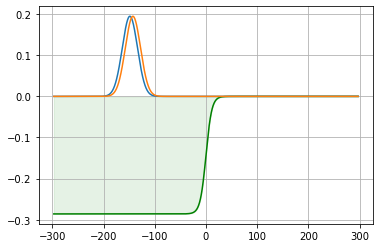

In [33]:
plt.grid()
plt.plot(z, V(z), color='g')
plt.fill_between(z, V(z), color='g', alpha=0.1)
plt.plot(z, np.abs(psi[0, :, 0]))
plt.plot(z, np.abs(psi[0, :, 49]))
plt.show()

If you want to generate animation, then you can use the following code below.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
#ax.tick_params(axis='x', which='both', direction='inout', length=10, width=2, labelsize=12)
ax.grid()
ymax = max(np.abs(psi[0, :, 0])) + 0.2
ymin = min(V(z)) - 0.2
ax.set_xlim(-Lz, Lz)
ax.set_ylim(ymin, ymax)
ax.plot(z, V(z), color='g', label='potential')
ax.fill_between(z, V(z), color='g', alpha=0.05)
ax.set_xlabel('z (atomic units)', weight='bold')
ax.set_ylabel(r'psi (|$\psi$|)', weight='bold')
ax.set_title('Split Operator Time Evolution', weight='bold')
line1, = ax.plot([], [])
line2, = ax.plot([], [])
plt.close()

def animate(i):
    global psi
    line1.set_data(z, np.abs(psi[0, :, i]))
    line2.set_data(z, np.abs(psi[1, :, i])*1e8)
    return line1, line2, 

anim = animation.FuncAnimation(fig, animate, interval=10, frames=4999, blit=True)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()